
=== Evaluating 80-20 split ===
⏩ Loaded Gradient Boosting model for 80-20 split
⏩ Loaded Random Forest model for 80-20 split
⏩ Loaded Logistic Regression model for 80-20 split
⏩ Loaded SVC model for 80-20 split


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          auc       mcc  precision     brier
Gradient Boosting    0.740193  0.750587   0.565197  0.883810
Random Forest        0.599183  0.657409   0.478403  0.592814
Logistic Regression  0.378198  0.299299   0.683840  0.204355
SVC                 -1.717574 -1.707294  -1.727439 -1.680979

=== Evaluating 70-30 split ===
⏩ Loaded Gradient Boosting model for 70-30 split
⏩ Loaded Random Forest model for 70-30 split
⏩ Loaded Logistic Regression model for 70-30 split
⏩ Loaded SVC model for 70-30 split


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          auc       mcc  precision     brier
Gradient Boosting    0.741239  0.739178   0.564626  0.819995
Random Forest        0.625683  0.690687   0.497655  0.620138
Logistic Regression  0.347279  0.273579   0.666632  0.256162
SVC                 -1.714200 -1.703444  -1.728913 -1.696295

=== Evaluating 60-40 split ===
⏩ Loaded Gradient Boosting model for 60-40 split
⏩ Loaded Random Forest model for 60-40 split
⏩ Loaded Logistic Regression model for 60-40 split
⏩ Loaded SVC model for 60-40 split


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          auc       mcc  precision     brier
Gradient Boosting    0.788974  0.734071   0.539651  0.824405
Random Forest        0.644635  0.681736   0.492556  0.647818
Logistic Regression  0.266646  0.290626   0.694978  0.217032
SVC                 -1.700255 -1.706433  -1.727186 -1.689256


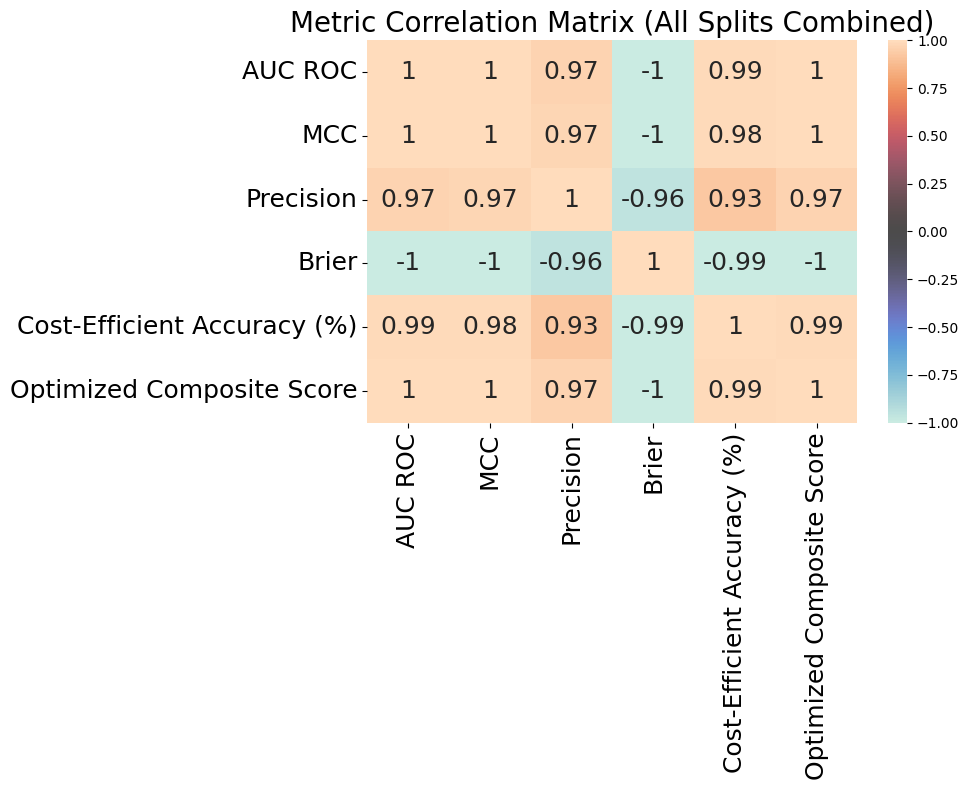


=== Performance Summary Across Splits ===

80-20 Split:
                     AUC ROC     MCC  Cost-Efficient Accuracy (%)  Precision  \
Gradient Boosting     0.7826  0.3992                        70.70     0.6586   
Random Forest         0.7609  0.3841                        68.69     0.6336   
Logistic Regression   0.7270  0.3259                        67.02     0.6927   
SVC                   0.4053  0.0000                        58.35     0.0000   

                      Brier  Optimized Composite Score  
Gradient Boosting    0.1340                     0.8243  
Random Forest        0.1386                     0.5885  
Logistic Regression  0.1447                     0.2792  
SVC                  0.1744                    -1.6919  

70-30 Split:
                     AUC ROC     MCC  Cost-Efficient Accuracy (%)  Precision  \
Gradient Boosting     0.7728  0.3909                        70.69     0.6497   
Random Forest         0.7582  0.3832                        69.13     0.6308   
Log

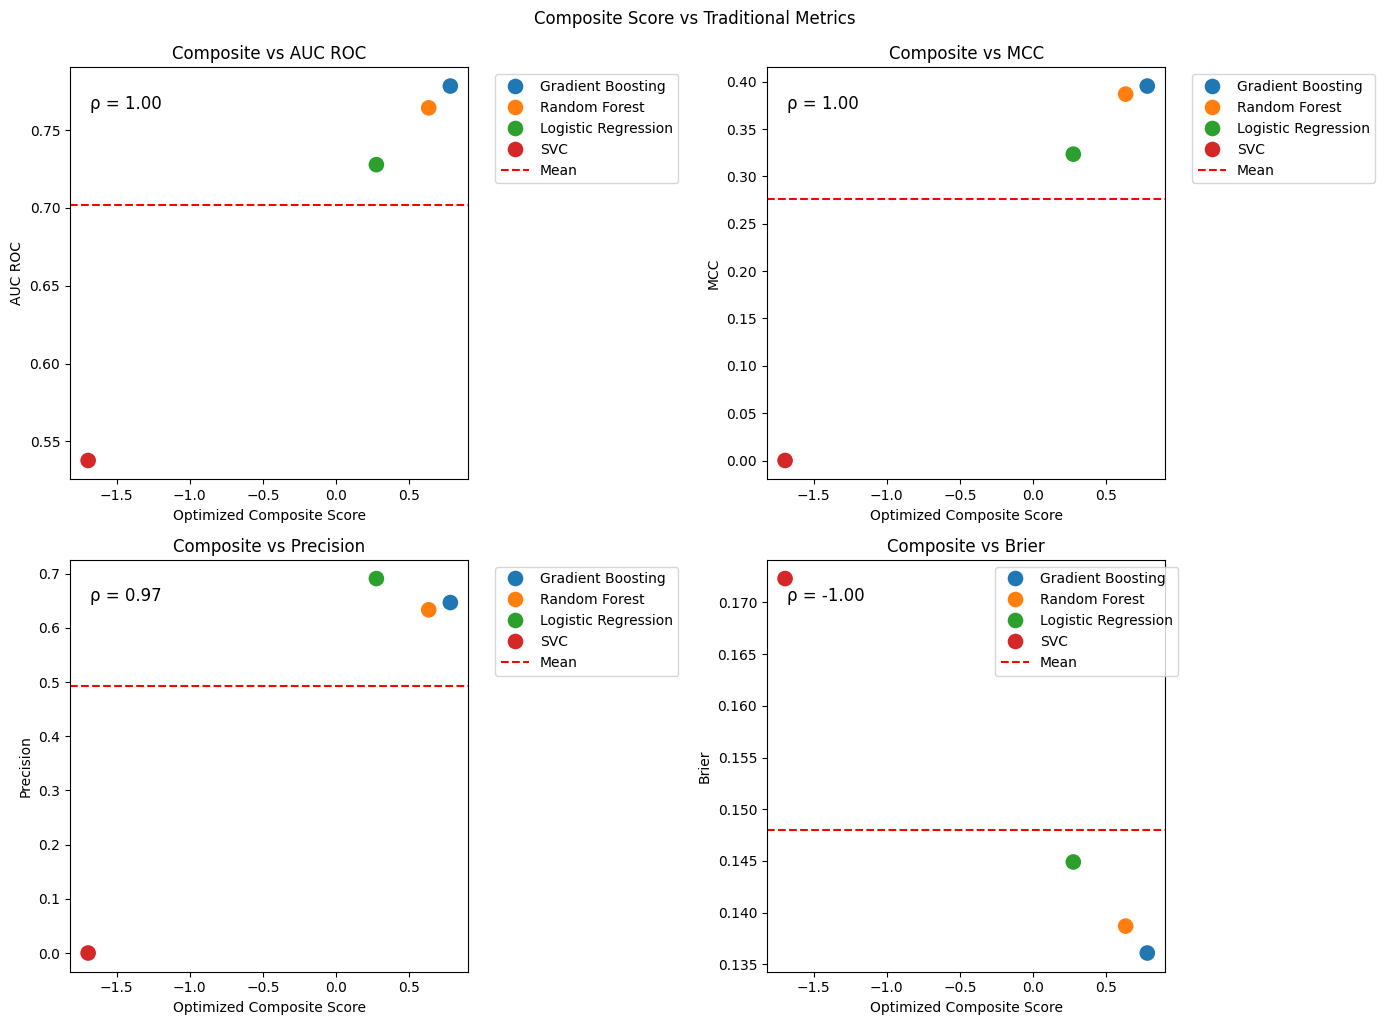

                      AUC ROC       MCC  Precision  \
Gradient Boosting    1.000000  1.000000   0.935899   
Random Forest        0.941812  0.978503   0.916510   
Logistic Regression  0.790108  0.818159   1.000000   
SVC                  0.000000  0.000000   0.000000   

                     Cost-Efficient Accuracy (%)  Optimized Composite Score  
Gradient Boosting                       1.000000                   1.000000  
Random Forest                           0.832930                   0.940306  
Logistic Regression                     0.662631                   0.795789  
SVC                                     0.000000                   0.000000  


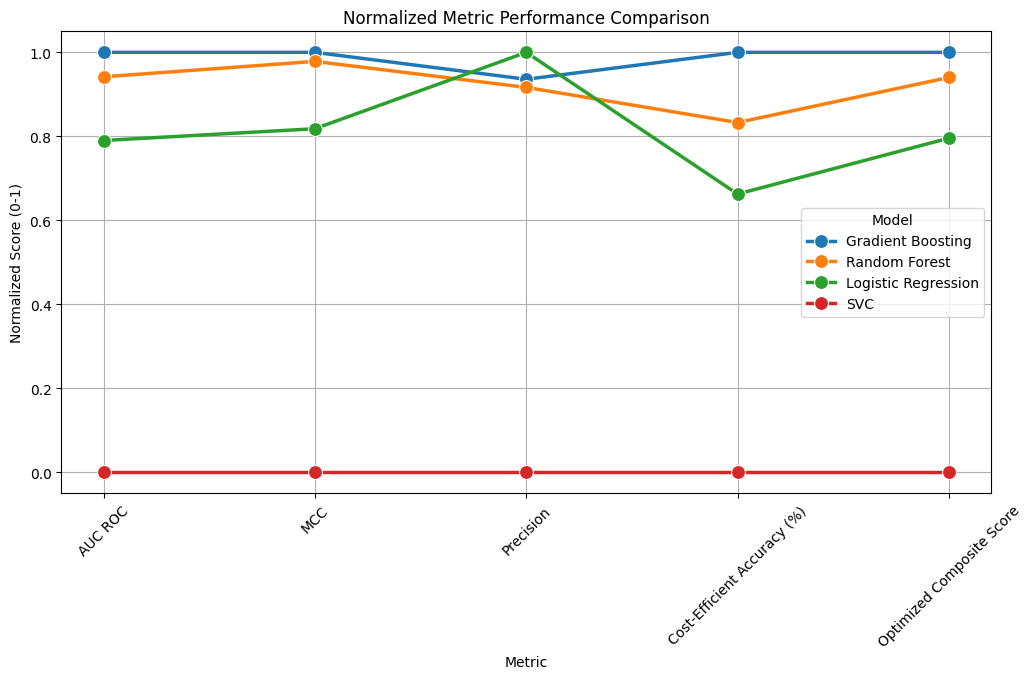

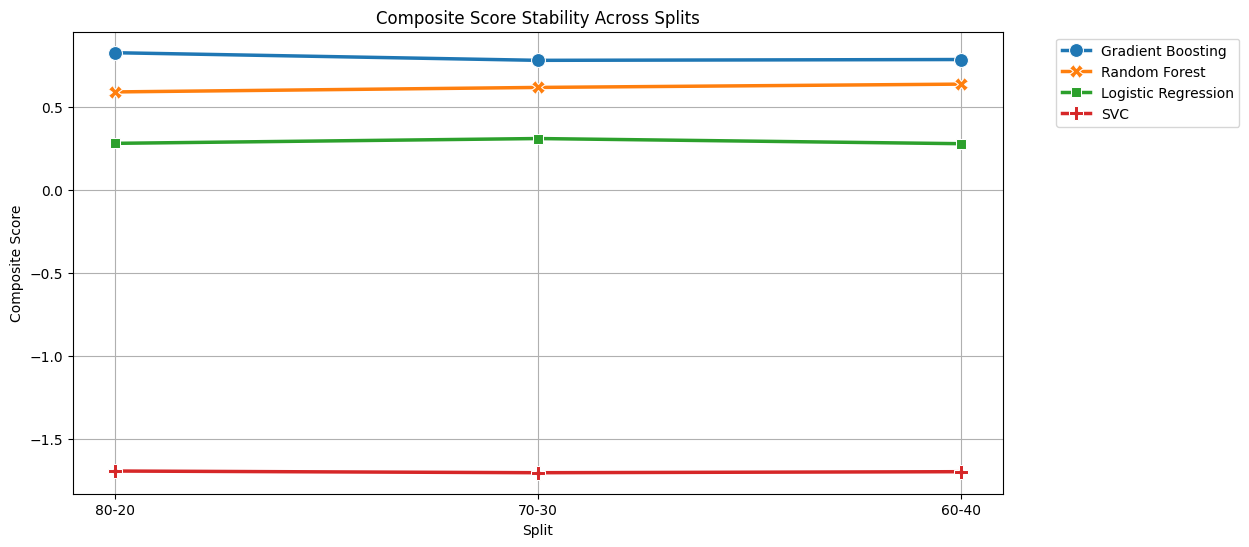

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, matthews_corrcoef, precision_score, brier_score_loss, accuracy_score
)
from scipy.stats import zscore
from scipy.optimize import minimize
from sklearn.base import clone
import seaborn as sns
import os
import joblib
from google.colab import files

# Load dataset and rename target
df = pd.read_excel("/content/default of credit card clients.xls")
df.rename(columns={"Default": "Target"}, inplace=True)

# Drop ID column if present
if 'ID' in df.columns:
    df.drop(columns=['ID'], inplace=True)

# Define features and target
X = df.drop('Target', axis=1)
y = df['Target']
X = pd.get_dummies(X, drop_first=True)  # One-hot encode categorical columns

# Define split configurations
split_configs = [
    {'name': '80-20', 'test_size': 0.2, 'random_state': 42},
    {'name': '70-30', 'test_size': 0.3, 'random_state': 42},
    {'name': '60-40', 'test_size': 0.4, 'random_state': 42}
]

# Initialize models
models = {
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=500, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVC": SVC(probability=True, max_iter=1000, random_state=42),
}

# Cost-sensitive setup
C_FN = 5
C_FP = 1
thresholds = np.arange(0.1, 0.9, 0.01)

# Storage for all results
all_results = []

for split in split_configs:
    print(f"\n=== Evaluating {split['name']} split ===")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=split['test_size'],
        random_state=split['random_state']
    )

    # Standardize (within split to prevent leakage)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Model checkpointing
    os.makedirs('saved_models', exist_ok=True)
    trained_models = {}
    for name, model in models.items():
        path = f"saved_models/{name}_{split['name']}.pkl"
        if os.path.exists(path):
            trained_models[name] = joblib.load(path)
            print(f"⏩ Loaded {name} model for {split['name']} split")
        else:
            trained_models[name] = clone(model).fit(X_train, y_train)
            joblib.dump(trained_models[name], path)
            print(f"⚙️ Trained {name} model for {split['name']} split")

    # Evaluation
    evaluation_summary = {}
    threshold_costs_plot = {}
    raw_metrics = {"auc": [], "mcc": [], "precision": [], "brier": []}

    total_bad = sum(y_test == 1)
    total_good = sum(y_test == 0)
    max_possible_cost = C_FN * total_bad + C_FP * total_good

    for name, model in trained_models.items():
        y_prob = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        auc = roc_auc_score(y_test, y_prob)
        y_pred_default = (y_prob >= 0.5).astype(int)
        mcc = matthews_corrcoef(y_test, y_pred_default)
        precision = precision_score(y_test, y_pred_default)
        brier = brier_score_loss(y_test, y_prob)

        raw_metrics["auc"].append(auc)
        raw_metrics["mcc"].append(mcc)
        raw_metrics["precision"].append(precision)
        raw_metrics["brier"].append(-brier)  # Negate for maximization

        # Cost-sensitive threshold tuning
        best_cost = float('inf')
        best_thresh = 0.5
        threshold_cost_pairs = []

        for t in thresholds:
            y_pred = (y_prob >= t).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            cost = C_FN * fn + C_FP * fp
            threshold_cost_pairs.append((t, cost))
            if cost < best_cost:
                best_cost = cost
                best_thresh = t
                best_tn, best_fp, best_fn, best_tp = tn, fp, fn, tp

        cost_eff_acc = (1 - best_cost / max_possible_cost) * 100

        evaluation_summary[name] = {
            "AUC ROC": round(auc, 4),
            "MCC": round(mcc, 4),
            "Precision": round(precision, 4),
            "Brier": round(brier, 4),
            "Best Threshold": round(best_thresh, 2),
            "Cost-Efficient Accuracy (%)": round(cost_eff_acc, 2),
            "Total Cost": best_cost,
            "TP": best_tp, "TN": best_tn, "FP": best_fp, "FN": best_fn
        }
        threshold_costs_plot[name] = threshold_cost_pairs

    # Composite scoring
    final_df = pd.DataFrame(evaluation_summary).T
    metric_df = pd.DataFrame(raw_metrics, index=models.keys())
    zscored = metric_df.apply(zscore)
    print("pineapple", zscored)

    X_metrics = zscored.values
    y_target = final_df["Cost-Efficient Accuracy (%)"].values

    # Constrained optimization
    weight_bounds = [
        (0.1, 0.9),  # AUC
        (0.1, 0.9),   # MCC
        (0.1, 0.9),   # Precision
        (0.1, 0.9)    # -Brier
    ]

    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'ineq', 'fun': lambda w: w[0] - 0.1},
        {'type': 'ineq', 'fun': lambda w: w[1] - 0.1},
        {'type': 'ineq', 'fun': lambda w: w[2] - 0.1},
        {'type': 'ineq', 'fun': lambda w: w[3] - 0.1}
    ]

    res = minimize(
        lambda w: -np.corrcoef(np.dot(X_metrics, w), y_target)[0, 1],
        [0.25, 0.25, 0.25, 0.25],
        bounds=weight_bounds,
        constraints=constraints,
        method='SLSQP'
    )

    opt_weights = np.round(res.x, 3)
    final_df["Optimized Composite Score"] = np.dot(X_metrics, opt_weights).round(4)
    final_df = final_df.sort_values("Optimized Composite Score", ascending=False)

    # Store results
    all_results.append({
        'split_name': split['name'],
        'final_df': final_df,
        'opt_weights': opt_weights,
        'threshold_costs': threshold_costs_plot
    })


plt.figure(figsize=(10, 8))
metrics_to_correlate = [
    'AUC ROC', 'MCC', 'Precision', 'Brier',
    'Cost-Efficient Accuracy (%)', 'Optimized Composite Score'
]

corr_matrix = final_df[metrics_to_correlate].corr()
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 18}, cmap='icefire', center=0, vmin=-1, vmax=1, alpha=0.8)
plt.title("Metric Correlation Matrix (All Splits Combined)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

# 1. Compare performance across splits
print("\n=== Performance Summary Across Splits ===")
for result in all_results:
    print(f"\n{result['split_name']} Split:")
    print(result['final_df'][['AUC ROC', 'MCC', 'Cost-Efficient Accuracy (%)', 'Precision', 'Brier', 'Optimized Composite Score']])

# 3. Compare composite weights
weights_df = pd.DataFrame(
    [r['opt_weights'] for r in all_results],
    index=[r['split_name'] for r in all_results],
    columns=['AUC', 'MCC', 'Precision', '-Brier']
)
print("\n=== Optimized Weights Across Splits ===")
print(weights_df)

# 2. Composite Score vs Traditional Metrics (Facet Grid)
plot_metrics = ['AUC ROC', 'MCC', 'Precision', 'Brier']
n_cols = 2
n_rows = int(np.ceil(len(plot_metrics) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5*n_rows))
axes = axes.flatten()

for i, metric in enumerate(plot_metrics):
    sns.scatterplot(
        data=final_df,
        x='Optimized Composite Score',
        y=metric,
        hue=final_df.index,
        s=150,
        ax=axes[i]
    )
    axes[i].axhline(
        y=np.mean(final_df[metric]),
        color='r',
        linestyle='--',
        label='Mean'
    )
    axes[i].set_title(f"Composite vs {metric}")
    axes[i].legend(bbox_to_anchor=(1.05, 1))

    # Add correlation annotation
    corr = np.corrcoef(
        final_df['Optimized Composite Score'],
        final_df[metric]
    )[0,1]
    axes[i].annotate(
        f"ρ = {corr:.2f}",
        xy=(0.05, 0.9),
        xycoords='axes fraction',
        fontsize=12
    )

plt.tight_layout()
plt.suptitle("Composite Score vs Traditional Metrics", y=1.02)
plt.show()

# 3. Performance Comparison: Composite vs Traditional Metrics
comparison_df = final_df[[
    'AUC ROC', 'MCC', 'Precision', 'Cost-Efficient Accuracy (%)', 'Optimized Composite Score'
]].copy()

# Normalize scores to [0,1] for comparison
comparison_df = (comparison_df - comparison_df.min()) / (comparison_df.max() - comparison_df.min())
print(comparison_df)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=comparison_df.reset_index().melt(
        id_vars='index',
        value_vars=comparison_df.columns
    ),
    x='variable',
    y='value',
    hue='index',
    marker='o',
    markersize=10,
    linewidth=2.5
)
plt.xticks(rotation=45)
plt.title("Normalized Metric Performance Comparison")
plt.ylabel("Normalized Score (0-1)")
plt.xlabel("Metric")
plt.legend(title='Model')
plt.grid(True)
plt.show()

composite_results = []
for result in all_results:
    for model in result['final_df'].index:
        composite_results.append({
            'Model': model,
            'Split': result['split_name'],
            'Composite Score': result['final_df'].loc[model, 'Optimized Composite Score'],
            'Cost Efficiency': result['final_df'].loc[model, 'Cost-Efficient Accuracy (%)']
        })
composite_df = pd.DataFrame(composite_results)

# 2. Plot composite score stability across splits for each model
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=composite_df,
    x='Split',
    y='Composite Score',
    hue='Model',
    style='Model',
    markers=True,
    dashes=False,
    markersize=10,
    linewidth=2.5
)
plt.title("Composite Score Stability Across Splits")
plt.ylabel("Composite Score")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()